In [1]:
from sys import path
path.append("./")

In [2]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from src.utils.data import get_dataset, load_dataset_subsample
from src.model.sklearn import MLPDropout
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

from scipy.stats import mode

In [3]:
path_to_subsample_info: str = "subsampled_tasks.csv"

tasks_to_use = load_dataset_subsample(path_to_subsample_info)
tasks_to_use = [int(el) for el in tasks_to_use]

num_folds: int = 3
random_seed: int = 42

In [4]:


def perform_baseline_prediction(x_train, y_train, x_val, y_val, name, task_type, output_size):

    # classifier = DecisionTreeClassifier(random_state=random_seed)
    # classifier = RandomForestClassifier(random_state=random_seed, n_estimators=100, n_jobs=-1)
    # classifier = MLPClassifier(random_state=random_seed, 
    #                            max_iter=50, 
    #                            alpha=0,
    #                            hidden_layer_sizes=(1000, 1000, 1000))
    classifier = MLPDropout(random_state=random_seed,
                            max_iter=50,
                            # alpha=0,
                            hidden_layer_sizes=(1000, 1000, 1000),
                            dropout=0.05,
                            mcdropout=True,)
    
    classifier.fit(x_train, y_train)
    mcdropout_num: int = 10
    y_preds = [classifier.predict(x_val) for _ in range(mcdropout_num)]
    y_pred = mode(y_preds, axis=0)[0]
    
    val_accuracy = accuracy_score(y_val, y_pred)
    val_f1 = f1_score(y_val, y_pred, average="binary" if task_type == 'binary classification' else "macro")
    val_mcc = matthews_corrcoef(y_val, y_pred)
    
    return {
        "task_name": name,
        "task_type": task_type,
        "output_size": output_size,
        "val_accuracy": val_accuracy,
        "val_f1": val_f1,
        "val_mcc": val_mcc
    }
    

def train(task_num: int, num_folds: int):
    
    x, y, name, task_type, output_size = get_dataset(task_num=task_num)

    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    
    kf = StratifiedKFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
    
    fold_results: list[dict] = []
    fold = 0
    for train_index, val_index in tqdm(kf.split(x, y), desc="Folds", colour="magenta", total=num_folds, disable=True):
        fold += 1
        
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]
        fold_result = perform_baseline_prediction(x_train, y_train, x_val, y_val, name, task_type, output_size)
        fold_result.update({"fold": fold, "task_num": task_num})
        fold_results.append(fold_result)
    return fold_results
    
        
    
baseline_results  = {task: train(task_num=task, num_folds=num_folds) 
                     for task in tqdm(tasks_to_use, desc="Tasks")}

Tasks:   0%|          | 0/20 [00:00<?, ?it/s]

/Users/leonardoalchieri/Desktop/GIT/MCDropoutHyperparameterAnalysis/src/model/sklearn.py:221: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leonardoalchieri/Desktop/GIT/MCDropoutHyperparameterAnalysis/src/model/sklearn.py:221: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leonardoalchieri/Desktop/GIT/MCDropoutHyperparameterAnalysis/src/model/sklearn.py:221: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leonardoalchieri/Desktop/GIT/MCDropoutHyperparameterAnalysis/src/model/sklearn.py:221: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/leonardoalchieri/Desktop/GIT/MCDropoutHyperparameterAnalysis/src/model/sklearn.py

In [5]:
def merge_fold_results(folds_list: list[dict]) -> dict:
    same_keys = ['task_name', 'task_type', 'output_size', 'task_num']
    different_keys = [key for key in folds_list[0].keys() if key not in same_keys]
    result = {
        key: folds_list[0][key] for key in same_keys
    }
    # we average the values when the keys are different
    for key in different_keys:
        result[key] = sum([fold[key] for fold in folds_list]) / len(folds_list)
    return result
        
    
baseline_results: dict[int, dict[str, float | int | str]] = {
    key: merge_fold_results(val) for key, val in baseline_results.items()
    }

In [6]:
baseline_results = pd.DataFrame.from_dict(baseline_results, orient='index')

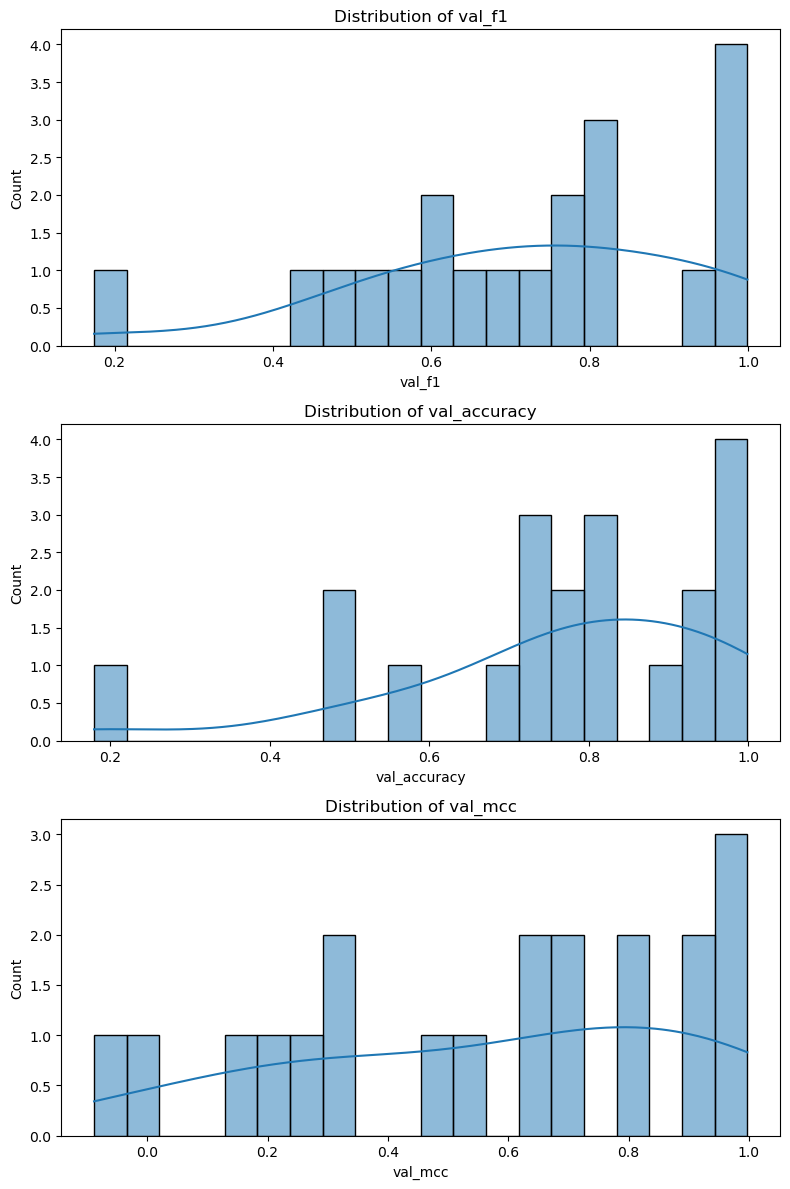

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

sns.histplot(data=baseline_results, x="val_f1", kde=True, ax=axes[0], bins=20)
axes[0].set_xlabel("val_f1")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of val_f1")

sns.histplot(data=baseline_results, x="val_accuracy", kde=True, ax=axes[1], bins=20)
axes[1].set_xlabel("val_accuracy")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of val_accuracy")

sns.histplot(data=baseline_results, x="val_mcc", kde=True, ax=axes[2], bins=20)
axes[2].set_xlabel("val_mcc")
axes[2].set_ylabel("Count")
axes[2].set_title("Distribution of val_mcc")

plt.tight_layout()
plt.show()


In [8]:
baseline_results['val_accuracy'].mean()

0.7729789958782984

# Testing mcdropout

In [4]:
classifier = MLPDropout(random_state=random_seed,
                            max_iter=50,
                            alpha=0,
                            hidden_layer_sizes=(1000, 1000, 1000),
                            dropout=0.05)

x, y, name, task_type, output_size = get_dataset(task_num=tasks_to_use[0])

classifier.fit(x[1:], y[1:])

MLPDropout(alpha=0, dropout=0.05, hidden_layer_sizes=(1000, 1000, 1000),
           max_iter=50, random_state=42)

In [19]:
for _ in range(5):
    print(classifier.predict(x[0].reshape(1, -1)))

[0.]
[0.]
[0.]
[0.]
[0.]


In [2]:
import torch
import torch.nn.functional as F
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)

In [3]:
target_2 = torch.tensor([[1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0]], dtype=torch.float32)

In [4]:
target_2

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [5]:
F.cross_entropy(input, target_2)

tensor(2.2799, grad_fn=<DivBackward1>)

In [6]:
print(accuracy_score(target, torch.argmax(input, dim=1)))
print(f1_score(target, torch.argmax(input, dim=1), average='macro'))

NameError: name 'accuracy_score' is not defined

In [7]:
print(accuracy_score(torch.argmax(target_2, dim=1), torch.argmax(input, dim=1)))
print(f1_score(torch.argmax(target_2, dim=1), torch.argmax(input, dim=1), average='macro'))
print(matthews_corrcoef(torch.argmax(target_2, dim=1), torch.argmax(input, dim=1)))

NameError: name 'accuracy_score' is not defined

In [8]:
torch.argmax(target_2, dim=1) == target

tensor([ True, False, False])

In [9]:
ex_arr1 = torch.softmax(torch.randn(3, 5, requires_grad=True), dim=1)
ex_arr2 = torch.sigmoid(torch.randn(3, 1, requires_grad=True), )

In [10]:
ex_arr2

tensor([[0.6833],
        [0.8505],
        [0.7468]], grad_fn=<SigmoidBackward0>)

In [11]:
ex_arr1

tensor([[0.4981, 0.1257, 0.1301, 0.1410, 0.1051],
        [0.3501, 0.0261, 0.1530, 0.0388, 0.4321],
        [0.2778, 0.3741, 0.1674, 0.1161, 0.0645]], grad_fn=<SoftmaxBackward0>)

In [12]:
torch.nanmean(ex_arr2, dim=0)

tensor([0.7602], grad_fn=<DivBackward0>)

In [56]:
mean = torch.nanmean(ex_arr1, dim=0)
mean_argmax = torch.argmax(mean, dim=0)
uncertainty = -torch.nansum(ex_arr1[:, mean_argmax] * torch.log(ex_arr1[:, mean_argmax]), dim=0)
uncertainty

In [34]:
-torch.nansum(ex_arr2 * torch.log(ex_arr2), dim=0)

tensor([1.0863], grad_fn=<NegBackward0>)

In [36]:
-torch.nansum(torch.argmax(ex_arr1, dim=0) * torch.log(torch.argmax(ex_arr1, dim=0)), dim=0)

tensor([0.8083, 0.8909, 0.5616, 0.8704, 0.5588], grad_fn=<NegBackward0>)

In [39]:
torch.argmax(ex_arr1, dim=1)

tensor([0, 1, 2])

In [28]:
torch.stack([torch.softmax(torch.randn(5, 1, requires_grad=True), dim=0) for _ in range(3)])

torch.Size([3, 5, 1])